Семинар 8 Данные из файла Volgmed_2013.xls (конкретные данные выбрать в соответствии с вариантом) очистить от выбросов и пропусков, найти коэффициенты простой линейной регрессии с их пи-значениями и коэффициент детерминации. Вывести на графике диаграмму рассеяния с линией регрессии, оценить пи-значение для этой модели на основании 20 000 стохастических моделирований.

Вариант 4. Сила правой руки юношей первого курса в зависимости от веса

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# Загрузка данных из файла Excel, начиная с 11 строки, т.к. до этого ненужная инфа
df = pd.read_excel("Volgmed_2013.xlsx", header = None, skiprows = 10)

# Добавление заголовков из 2 строки
headers = pd.read_excel("Volgmed_2013.xlsx", header = 0, nrows = 1).iloc[0].tolist()
df.columns = headers

In [2]:
#Выбор данных, очистка от выбросов и пропусков
data = df[['Пол', 'Курс', 'Сила правой руки, кг', 'Вес, кг']]

data = data.loc[((data['Пол'] == 'муж') | (data['Пол'] == 'муж.')) & (data['Курс'] == 1)]

for col in ['Курс', 'Сила правой руки, кг', 'Вес, кг']:
    data = data[pd.to_numeric(data[col], errors = 'coerce').notna()]

data.dropna(subset = ['Пол', 'Курс', 'Сила правой руки, кг', 'Вес, кг'], inplace = True)

x_arr = data['Сила правой руки, кг'].to_numpy()
q_025 = np.quantile(x_arr, 0.25)
q_075 = np.quantile(x_arr, 0.75)
iqd = q_075 - q_025
upper_threshold = q_075 + 1.5 * iqd
lower_threshold = q_025 - 1.5 * iqd

data =  data.loc[(data['Сила правой руки, кг'] <= upper_threshold) & (data['Сила правой руки, кг'] >= lower_threshold)]

y_arr = data['Вес, кг'].to_numpy()
q_025 = np.quantile(y_arr, 0.25)
q_075 = np.quantile(y_arr, 0.75)
iqd = q_075-q_025
upper_threshold = q_075 + 1.5 * iqd
lower_threshold = q_025 - 1.5 * iqd
data =  data.loc[ (data['Вес, кг'] <= upper_threshold) & (data['Вес, кг'] >= lower_threshold)]

data_sort_by_strength = data.sort_values(by = 'Сила правой руки, кг')

data_sort_by_strength

,Пол,Курс,"Сила правой руки, кг","Вес, кг"
3462,муж,1.0,24.0,60
3997,муж,1.0,24.0,54.5
4065,муж,1.0,24.0,69.5
2747,муж.,1.0,24.0,55
2743,муж.,1.0,27.0,58
...,...,...,...,...
423,муж,1.0,80.0,71
925,муж,1.0,80.0,71.5
863,муж,1.0,80.0,68.5
561,муж,1.0,82.0,84


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.29
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           0.000538
Time:                        15:09:27   Log-Likelihood:                -919.36
No. Observations:                 260   AIC:                             1843.
Df Residuals:                     258   BIC:                             1850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.6713      2.195     26.724      0.0

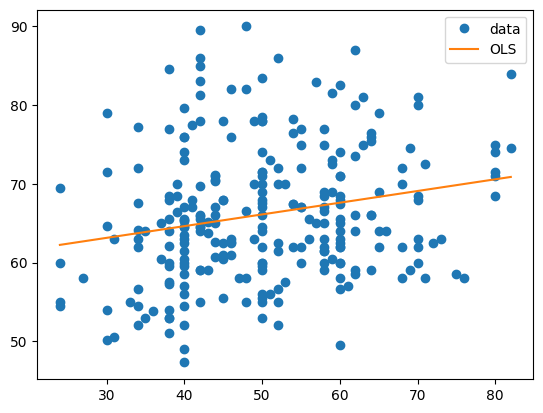

Коэффициент детерминации 0.04545772058141484
Коэффициенты с их оценкой пи-значений:
Константа: 58.671289784189476 (p-значение: 2.7734763177293025e-76)
Рост: 0.14886049575983545 (p-значение: 0.0005377823972899918)


In [3]:
#Нахождение коэффициентов простой линейной регрессии с их пи-значениями и коэффициента детерминации
strength = data_sort_by_strength['Сила правой руки, кг'].to_numpy(dtype = float)
weight = data_sort_by_strength['Вес, кг'].to_numpy(dtype = float)
X1 = sm.add_constant(strength)
model = sm.OLS(weight, X1)
res = model.fit()
print(res.summary())
plt.plot(strength, weight, "o", label = 'data')
plt.plot(strength, res.fittedvalues, label = 'OLS')
plt.legend()
plt.show()
print('Коэффициент детерминации', res.rsquared)
print('Коэффициенты с их оценкой пи-значений:')
names = ['Константа', 'Рост']
for i in range(len(res.params)):
    print(f"{names[i]}: {res.params[i]} (p-значение: {res.pvalues[i]})")

In [4]:
#Эмпирический мост и верхняя оценка p-value
simple_regr_res = weight - res.fittedvalues
sum_regr_res = np.cumsum(simple_regr_res)
sigma = np.std(simple_regr_res)
emp_bridge = sum_regr_res / len(sum_regr_res) ** 0.5 / sigma
J = np.max(np.abs(emp_bridge))
p_value = stats.kstwobign.sf(J)
print('J_n =', J)
print('upper_p_value =', p_value)

J_n = 0.9774291459513368
upper_p_value = 0.2949842717361301


In [5]:
n_iter = 20000
n = len(strength)
counter = 0
for i in range(n_iter):
  Y_temp = stats.norm.rvs(0, 1, n) * sigma + strength
  res = sm.OLS(Y_temp, X1).fit()
  simple_regr_res = Y_temp - res.fittedvalues
  sum_regr_res = np.cumsum(simple_regr_res)
  emp_bridge = sum_regr_res / len(sum_regr_res) ** 0.5 / np.std(simple_regr_res)
  J_temp = np.max(np.abs(emp_bridge))
  if J_temp > J:
    counter += 1
print('Эмпирическое пи-значение =', counter / n_iter)

Эмпирическое пи-значение = 0.0264
